# Data preparation

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr

## Load customer dataset

In [3]:
orders = pd.read_csv('/content/drive/My Drive/DM/Data_Preparation/customer_supermarket_cleaned_orders.csv', sep='\t', index_col=0).reset_index()
orders['BasketDate'] = pd.to_datetime(orders.BasketDate, format='%Y/%m/%d %H:%M')

In [ ]:
orders.head()

,BasketID,ProdID,BasketDate,CustomerCountry,Sale,CustomerID,ProdDescr,Qta,BasketDay,BasketMonth,BasketWeekOfYear,BasketYear,BasketWeekOfMonth,Tot
0,536365,21730,2010-12-01 08:26:00,United Kingdom,4.25,17850.0,GLASS STAR FROSTED T-LIGHT HOLDER,6,2,12,48,2010,1,25.50
1,536365,22752,2010-12-01 08:26:00,United Kingdom,7.65,17850.0,SET 7 BABUSHKA NESTING BOXES,2,2,12,48,2010,1,15.30
2,536365,71053,2010-12-01 08:26:00,United Kingdom,3.39,17850.0,WHITE METAL LANTERN,6,2,12,48,2010,1,20.34
3,536365,84029E,2010-12-01 08:26:00,United Kingdom,3.39,17850.0,RED WOOLLY HOTTIE WHITE HEART.,6,2,12,48,2010,1,20.34
4,536365,84029G,2010-12-01 08:26:00,United Kingdom,3.39,17850.0,KNITTED UNION FLAG HOT WATER BOTTLE,6,2,12,48,2010,1,20.34


## Indicators

In [ ]:
# Number of baskets per customer ('NumBaskets')
def get_total_baskets(df,column_name):
  res = df.groupby(['CustomerID']).BasketID.nunique().to_frame(column_name).reset_index()
  return res

# Number of distinct products per customer ('NumProducts')
def get_total_distinct_products(df,column_name):
  res = df.groupby(['CustomerID']).ProdID.nunique().to_frame(column_name).reset_index()
  return res

# Number products (quantity) per customer ('TotalProducts')
def get_total_products(df,column_name):
  res = df.groupby(['CustomerID']).Qta.sum().to_frame(column_name).reset_index()
  return res

# Maximum number of items in a basket per customer ('MaxProd')
def get_max_basket_size(df,column_name):
  res = df.groupby(['CustomerID', 'BasketID']).Qta.sum().reset_index()
  res = res.groupby('CustomerID').Qta.max().to_frame(column_name).reset_index()
  return res

# Avg/Std basket size (in number of distinct products) per customer ('BasketSize_')
def get_basket_size_stat(df, measure,column_name):
  res = df.groupby(['CustomerID', "BasketWeekOfYear", "BasketYear"]).ProdID.count().reset_index()
  if measure == 'mean':
    res = res.groupby('CustomerID').ProdID.mean().to_frame(column_name+measure).reset_index()
  return res

# Avg/Std basket 'Qta' per customer ('BasketTotSize_')
def get_basket_total_size_stat(df, measure,column_name):
  res = df.groupby(['CustomerID', "BasketWeekOfYear", "BasketYear"]).Qta.sum().reset_index()
  if measure == 'mean':
    res = res.groupby('CustomerID').Qta.mean().to_frame(column_name+measure).reset_index()
  return res

# Avg/Std basket 'Tot' per customer ('BasketSaleSize_')
def get_basket_tot_stat(df, measure,column_name):
  res = df.groupby(['CustomerID', "BasketWeekOfYear", "BasketYear"]).Tot.sum().reset_index()
  if measure == 'mean':
    res = res.groupby('CustomerID').Tot.mean().to_frame(column_name+measure).reset_index()
  return res

# Avg/Std basket 'Sale' per customer ('BasketSaleSize_')
def get_basket_sale_stat(df, measure,column_name):
  res = df.groupby(['CustomerID', "BasketWeekOfYear", "BasketYear"]).Sale.sum().reset_index()
  if measure == 'mean':
    res = res.groupby('CustomerID').Sale.mean().to_frame(column_name+measure).reset_index()
  return res

def categorize(x):
    m = x.sum()
    size = len(x)
    m = m/(size - 1) if (size > 1) else 53
    return m

# ('distance_in_time_purchase')
def get_distance_in_time_purchases_stat(df,column_name): 
  res = df.groupby(['CustomerID','BasketYear','BasketWeekOfYear']).BasketYear.min().to_frame('minDate').reset_index()
  del res['minDate']

  res.loc[0, column_name] = 0
  previous_year = res.loc[0, 'BasketYear']
  previous_week = res.loc[0, 'BasketWeekOfYear']
  previous_customer = res.loc[0, 'CustomerID']
  
  for i in range(1, len(res)):
    current_year = res.loc[i, 'BasketYear']
    current_week = res.loc[i, 'BasketWeekOfYear']
    current_customer = res.loc[i, 'CustomerID']

    if previous_customer == current_customer:
      res.loc[i, column_name] = (current_year - previous_year) * 52 + (current_week - previous_week)
    else:
      res.loc[i, column_name] = 0
    previous_year = current_year
    previous_week = current_week
    previous_customer = current_customer

  res = res.groupby(['CustomerID']).agg({column_name:categorize}).reset_index()
  return res

In [ ]:
data = get_total_baskets(orders, 'NumBaskets')

res = get_total_distinct_products(orders,'NumProducts')
data['NumProducts'] = res['NumProducts']

res = get_total_products(orders,'TotalProducts')
data['TotalProducts'] = res['TotalProducts']

res = get_max_basket_size(orders,'MaxProd')
data['MaxProd'] = res['MaxProd']


res = get_distance_in_time_purchases_stat(orders,'distance_in_time_purchase')
data['distance_in_time_purchase'] = res['distance_in_time_purchase']

### Entropy 

In [ ]:
def total_column_distribution_among_baskets(df, path, column, bins=30):
  df_plot = df.groupby(['CustomerID','BasketWeekOfYear','BasketYear'])[column].sum().to_frame(column)
  
  df_plot.plot.hist(by=column,bins=bins, figsize = (16,8))
  plt.gca().set_xlabel(column)
  plt.title(column + ' distribution')
  plt.savefig(path)

def total_column_distribution_among_baskets_c(df, path, column, bins=30):
  df_plot = df.groupby(['CustomerID', 'BasketWeekOfYear','BasketYear'])[column].count().to_frame(column)
  #df_plot = df_plot.groupby(['BasketWeekOfYear','BasketYear'])[column].mean().to_frame(column)
  
  df_plot.plot.hist(by=column,bins=bins, figsize = (16,8))
  plt.gca().set_xlabel(column)
  plt.title(column + ' distribution')
  plt.savefig(path)

def total_column_distribution_sale(df, path, column, bins=1000):
  df_plot = df.groupby(['CustomerID','BasketWeekOfYear','BasketYear'])[column].mean().to_frame(column)
  
  df_plot.plot.hist(by='Sale',bins=bins, figsize = (16,8))
  plt.gca().set_xlabel(column)
  plt.title(column + ' distribution')
  plt.savefig(path)

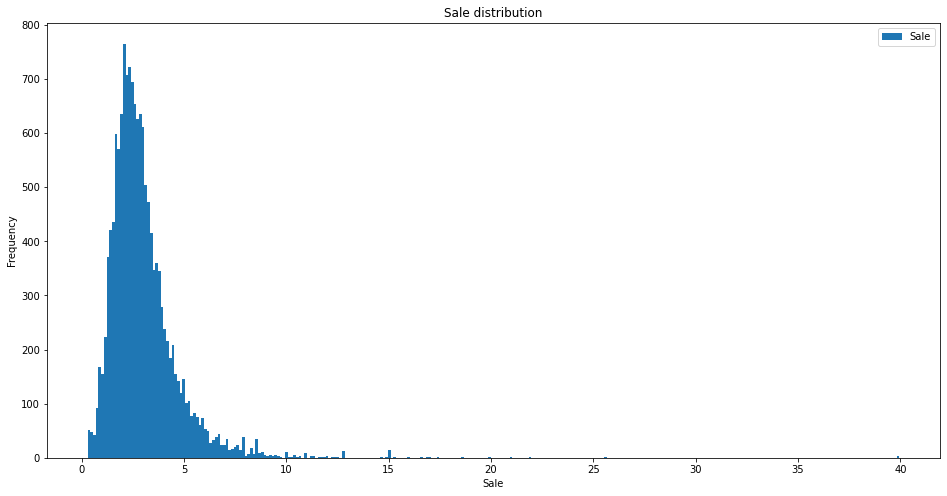

In [ ]:
total_column_distribution_sale(orders,'/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Sale_among_weeks.png','Sale',300)

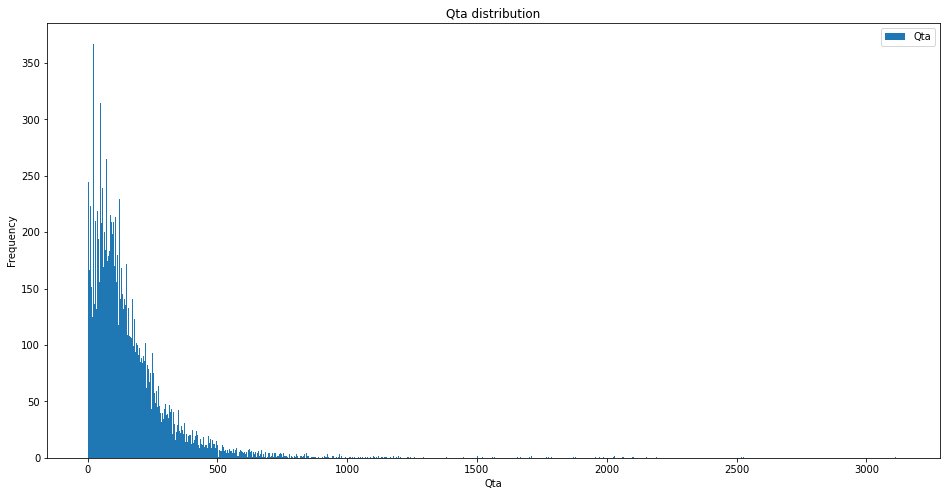

In [ ]:
total_column_distribution_among_baskets(orders, '/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Qta_among_weeks', 'Qta',bins = 1000)

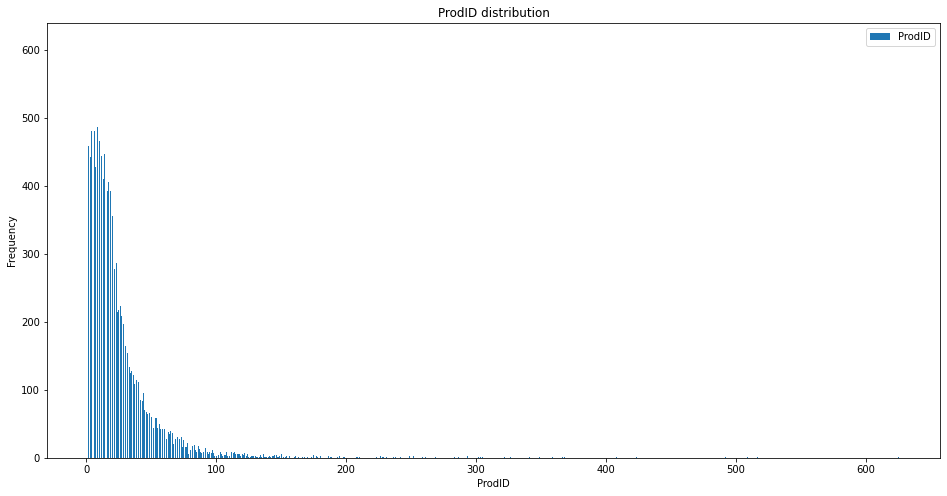

In [ ]:
total_column_distribution_among_baskets_c(orders, '/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/ProdID_among_weeks', 'ProdID',1000)

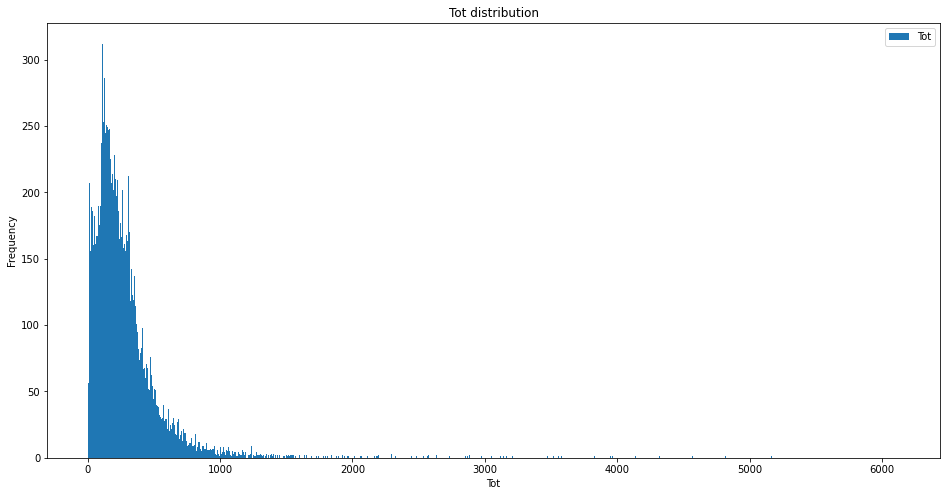

In [ ]:
total_column_distribution_among_baskets(orders, '/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Tot_among_weeks', 'Tot',1000)

In [ ]:
from pandas.core.algorithms import value_counts 
from scipy.stats import entropy

def apply_entropy(values, thresholds):
  # Discretize
  size = len(thresholds)
  classes_count = np.zeros(size+1)

  for value in values:
    for (i, t) in enumerate(thresholds):
      if value <= t:
        classes_count[i] += 1
        break
    
    if value > thresholds[size-1]:
      classes_count[size] += 1

  return entropy(classes_count, base=2) / math.log2(size+1)

def column_entropy(df, column_name, new_column, entropy_f):
  serie = df.groupby(["CustomerID", "BasketWeekOfYear", "BasketYear"])[column_name].sum().reset_index()
  return serie.groupby(["CustomerID"]).agg({column_name:entropy_f})[column_name].to_frame(new_column).reset_index()

def column_entropy_c(df, column_name, new_column, entropy_f):
  serie = df.groupby(["CustomerID", "BasketWeekOfYear", "BasketYear"])[column_name].count().reset_index()
  return serie.groupby(["CustomerID"]).agg({column_name:entropy_f})[column_name].to_frame(new_column).reset_index()

def column_entropy_m(df, column_name, new_column, entropy_f):
  serie = df.groupby(["CustomerID", "BasketWeekOfYear", "BasketYear"])[column_name].mean().reset_index()
  return serie.groupby(["CustomerID"]).agg({column_name:entropy_f})[column_name].to_frame(new_column).reset_index()

In [ ]:
def qta_entropy(x):
  return apply_entropy(x, [59, 212])
data['Qta_entropy'] = column_entropy(orders, "Qta", "Qta_entropy", qta_entropy)['Qta_entropy'];

res = get_basket_total_size_stat(orders, 'mean','BasketTotSize_')
data['Qta_mean'] = res['BasketTotSize_mean']

In [ ]:
def prod_count_entropy(x):
  return apply_entropy(x, [8,29])
data['#ProdID_entropy'] = column_entropy_c(orders, "ProdID", "#ProdID_entropy", prod_count_entropy)['#ProdID_entropy'];

res = get_basket_size_stat(orders, 'mean','BasketSaleSize_')
data['#ProdID_mean'] = res['BasketSaleSize_mean']

In [ ]:
def tot_entropy(x):
  return apply_entropy(x, [120, 350])
data['Tot_entropy'] = column_entropy(orders, "Tot", "Tot_entropy", tot_entropy)['Tot_entropy'];

res = get_basket_tot_stat(orders, 'mean','BasketSize_')
data['Tot_mean'] = res['BasketSize_mean']

In [ ]:
def sale_entropy(x):
  return apply_entropy(x, [2, 3.6])
data['Sale_entropy'] = column_entropy_m(orders, "Sale", "Sale_entropy", sale_entropy)['Sale_entropy'];

res = get_basket_sale_stat(orders, 'mean','BasketSale_')
data['Sale_mean'] = res['BasketSale_mean']

In [ ]:
data.head()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean
0,12347.0,7,96,1774,496,8.666667,0.621610,253.428571,0.373304,23.285714,0.544568,436.588571,0.373304,60.191429
1,12348.0,3,6,140,96,8.000000,0.579380,46.666667,0.000000,2.000000,0.000000,30.066667,0.000000,1.300000
2,12349.0,1,66,530,530,53.000000,0.000000,530.000000,0.000000,66.000000,0.000000,1145.350000,0.000000,265.200000
3,12350.0,1,16,196,196,53.000000,0.000000,196.000000,0.000000,16.000000,0.000000,294.400000,0.000000,25.300000
4,12352.0,7,57,526,125,6.166667,0.544568,75.142857,0.621610,11.000000,0.373304,197.962857,0.621610,44.830000


In [ ]:
data.describe()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean
count,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000,4172.000000
mean,15298.341802,3.944871,59.187200,569.706616,213.343960,27.110185,0.268094,156.586728,0.244150,22.516857,0.257600,268.599544,0.285485,63.387513
std,1719.012081,6.866912,82.025531,1182.387911,196.997079,21.344164,0.323244,147.268376,0.311065,21.419832,0.322074,239.876822,0.336052,61.501438
min,12347.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.900000,0.000000,0.290000
25%,13820.500000,1.000000,15.000000,109.000000,85.000000,7.285714,0.000000,69.000000,0.000000,9.000000,0.000000,133.058333,0.000000,25.285000
50%,15297.500000,2.000000,34.000000,266.000000,163.000000,16.666667,0.000000,122.000000,0.000000,17.000000,0.000000,216.736250,0.000000,48.487500
75%,16777.250000,4.000000,75.000000,660.000000,281.000000,53.000000,0.579380,204.500000,0.579380,28.814286,0.579380,336.151250,0.612602,84.775000
max,18287.000000,196.000000,1719.000000,46993.000000,2519.000000,53.000000,1.000000,2519.000000,1.000000,328.333333,1.000000,4569.740000,1.000000,1337.260000


### Outliers

In [5]:
columns = [
  'NumBaskets',
  'NumProducts',
  'TotalProducts',
  'MaxProd',
  'distance_in_time_purchase',
  'Qta_entropy',
  'Qta_mean',
  '#ProdID_entropy',
  '#ProdID_mean',
  'Tot_entropy',
  'Tot_mean',
  'Sale_entropy',
  'Sale_mean'
]

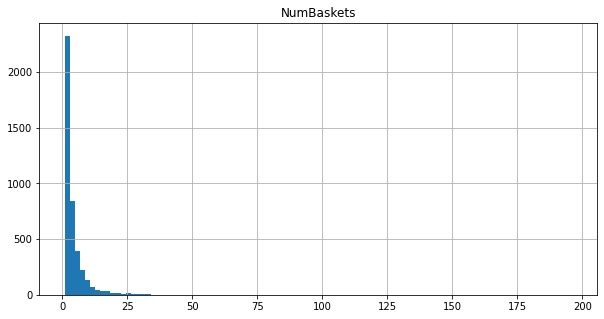

<Figure size 432x288 with 0 Axes>

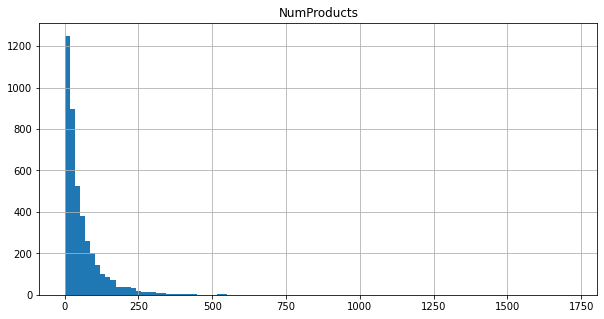

<Figure size 432x288 with 0 Axes>

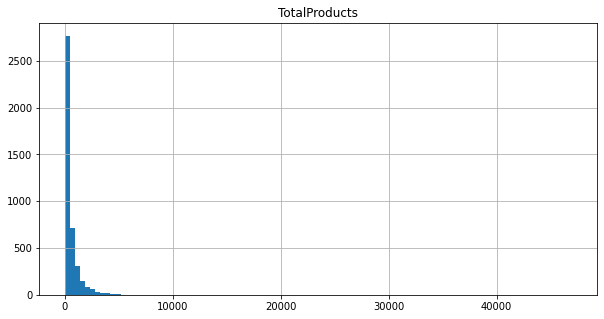

<Figure size 432x288 with 0 Axes>

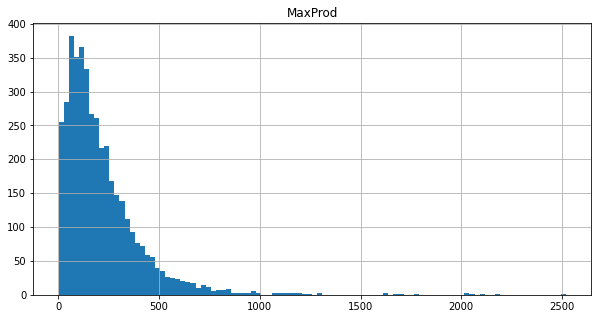

<Figure size 432x288 with 0 Axes>

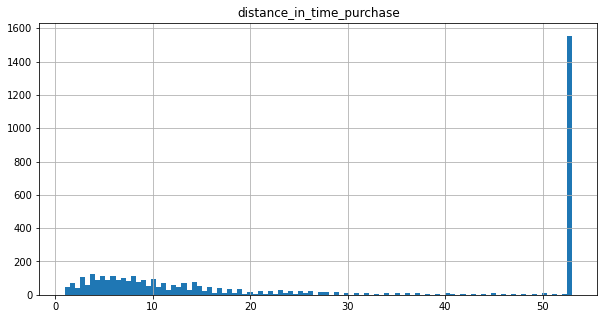

<Figure size 432x288 with 0 Axes>

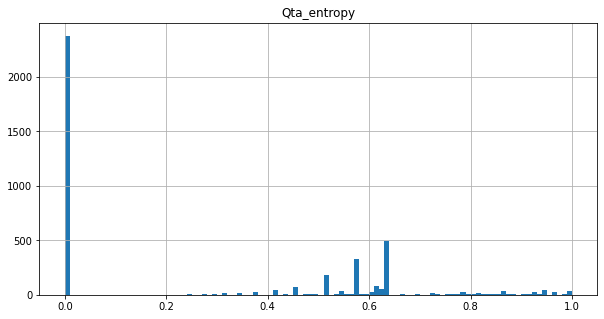

<Figure size 432x288 with 0 Axes>

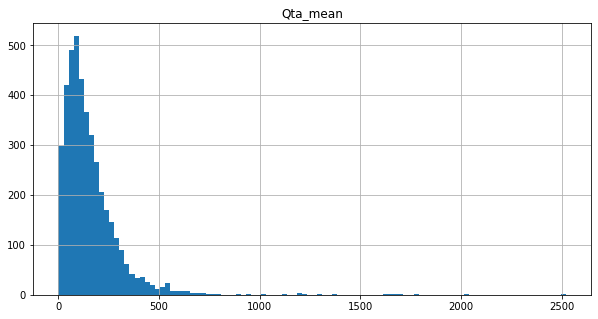

<Figure size 432x288 with 0 Axes>

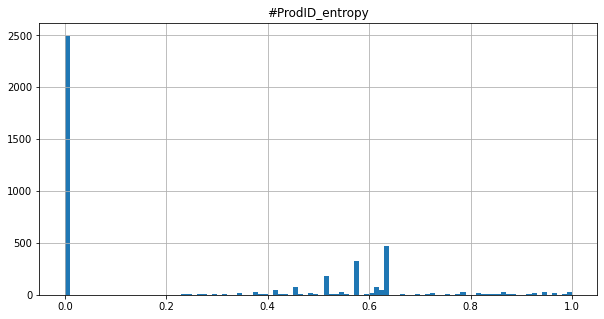

<Figure size 432x288 with 0 Axes>

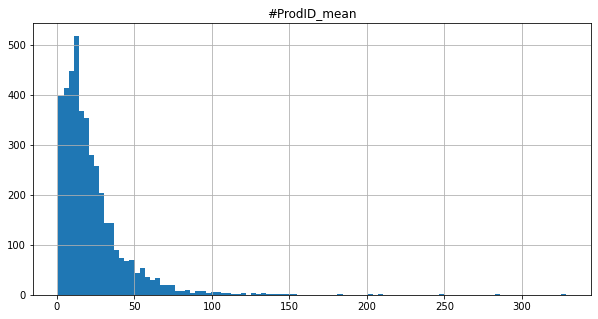

<Figure size 432x288 with 0 Axes>

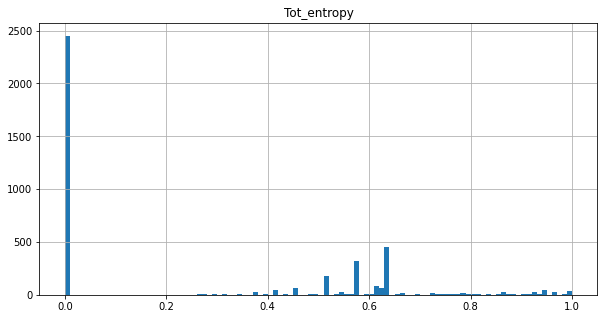

<Figure size 432x288 with 0 Axes>

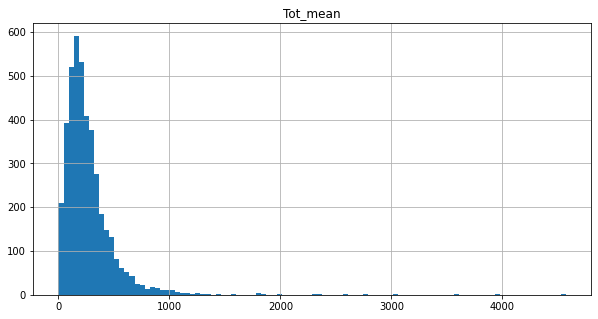

<Figure size 432x288 with 0 Axes>

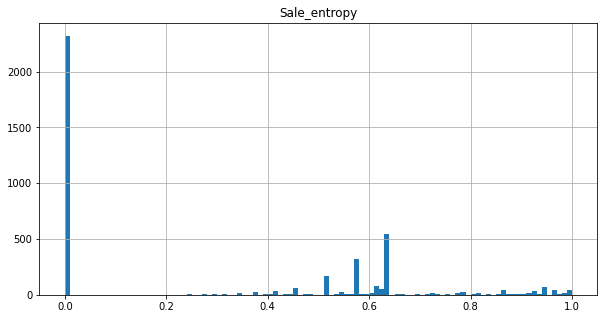

<Figure size 432x288 with 0 Axes>

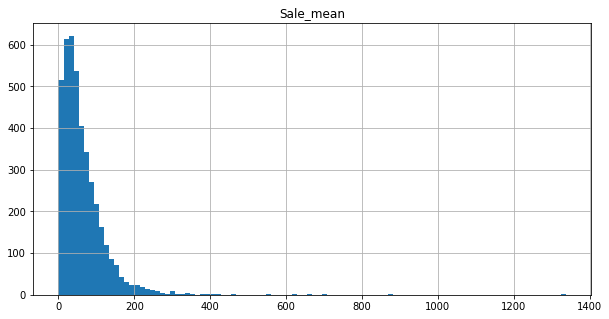

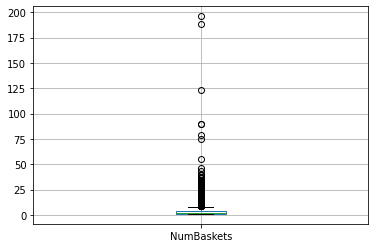

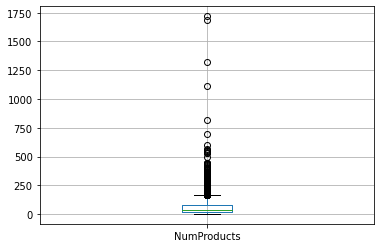

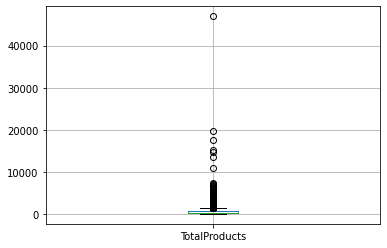

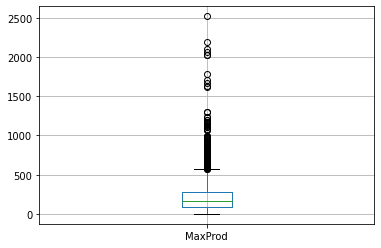

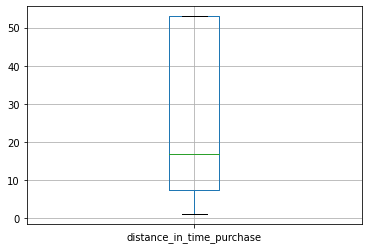

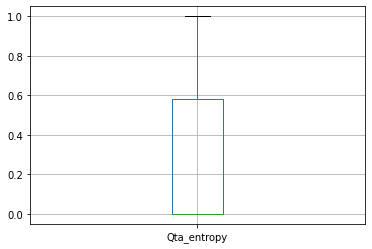

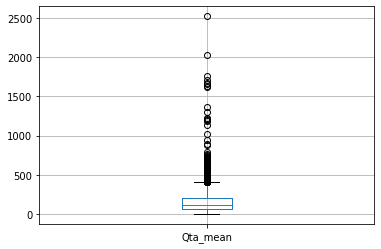

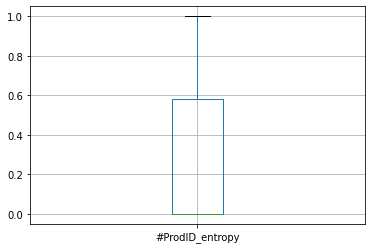

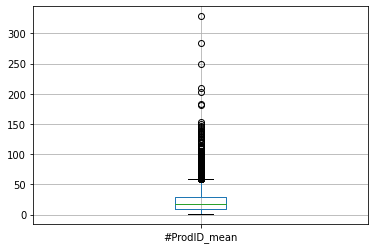

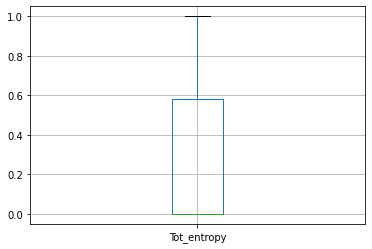

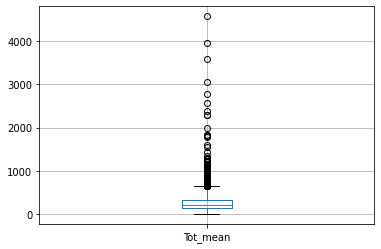

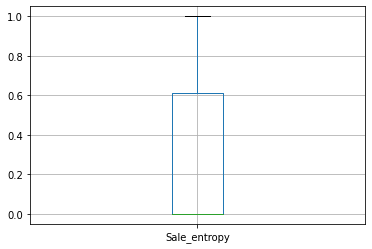

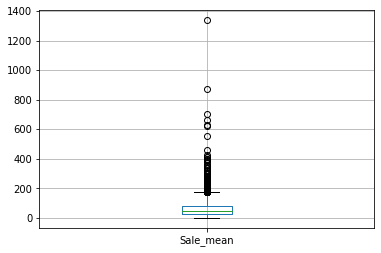

<Figure size 432x288 with 0 Axes>

In [ ]:

for column in columns:
  data.hist(column=column, bins=100, figsize = (10,5))
  plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/Raw/'+ column +'_hist.pdf')
  plt.show()
  plt.clf()


for column in columns:
  data.boxplot(column=column, figsize = (10,5))
  plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/Raw/'+ column +'_boxplot.pdf')
  plt.show()
  plt.clf()

In [ ]:
clean_data = data.copy()
print('Customer before removal: ' +str(len(clean_data)))
clean_data = clean_data[clean_data["NumBaskets"] < 50]
clean_data = clean_data[clean_data["NumProducts"] < 500]
clean_data = clean_data[clean_data["TotalProducts"] < 5000]
clean_data = clean_data[clean_data["MaxProd"] < 1000]
clean_data = clean_data[clean_data["Qta_mean"] < 800]
clean_data = clean_data[clean_data["#ProdID_mean"] < 150]
clean_data = clean_data[clean_data["Tot_mean"] < 1400]
clean_data = clean_data[clean_data["Sale_mean"] < 350]
print('Customer after removal: ' +str(len(clean_data)))

Customer before removal: 4172
Customer after removal: 4110


In [ ]:
clean_data.to_csv('/content/drive/MyDrive/DM/Clustering/customer_indicators_all_features_unnormalized.csv')

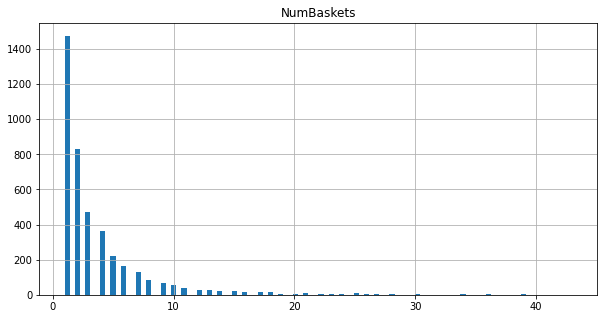

<Figure size 432x288 with 0 Axes>

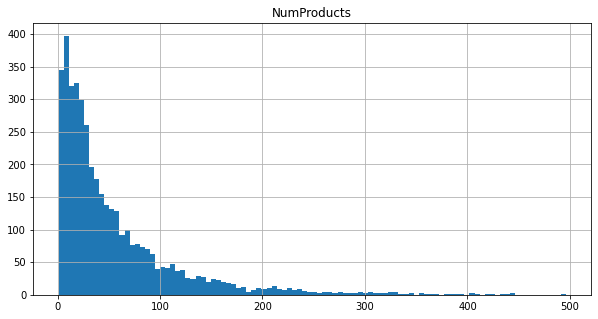

<Figure size 432x288 with 0 Axes>

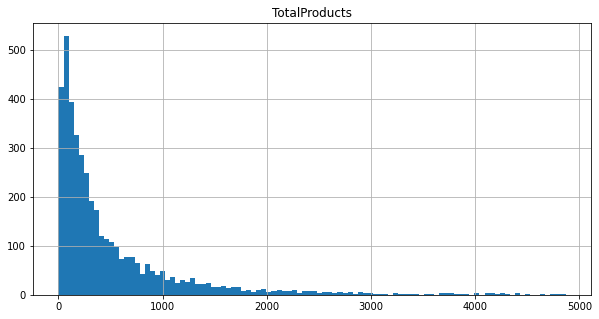

<Figure size 432x288 with 0 Axes>

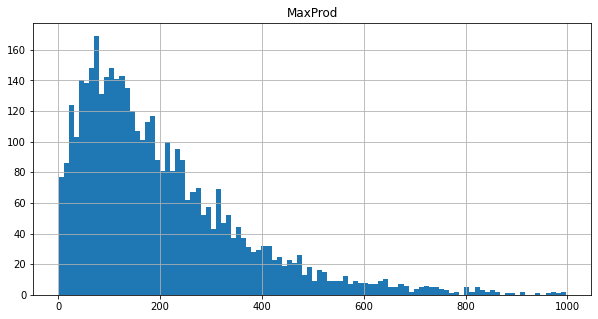

<Figure size 432x288 with 0 Axes>

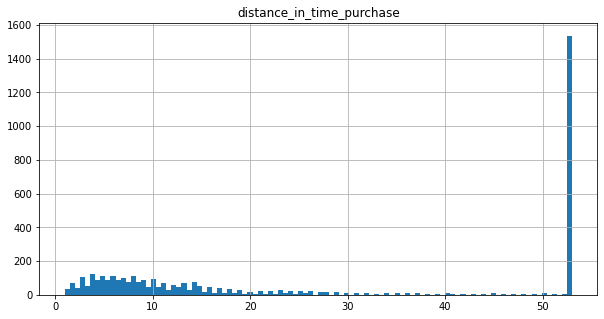

<Figure size 432x288 with 0 Axes>

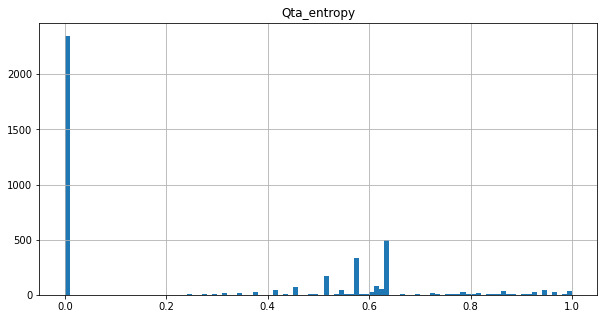

<Figure size 432x288 with 0 Axes>

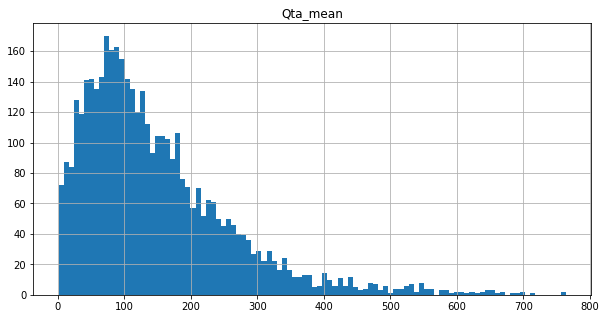

<Figure size 432x288 with 0 Axes>

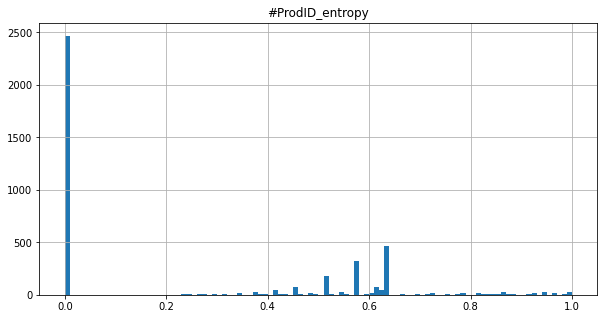

<Figure size 432x288 with 0 Axes>

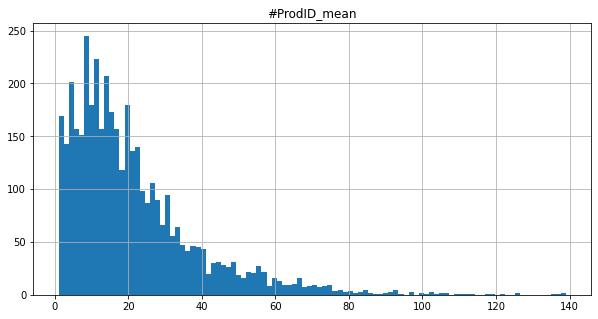

<Figure size 432x288 with 0 Axes>

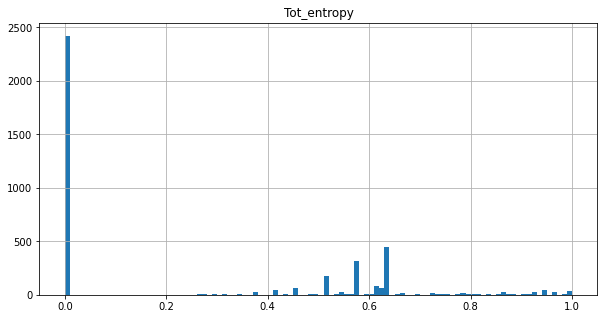

<Figure size 432x288 with 0 Axes>

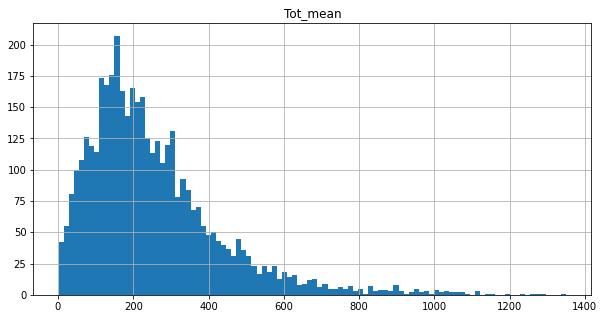

<Figure size 432x288 with 0 Axes>

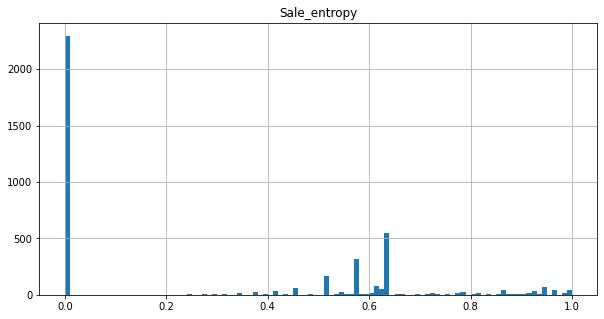

<Figure size 432x288 with 0 Axes>

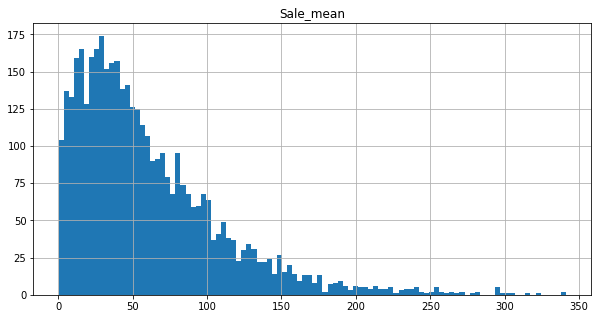

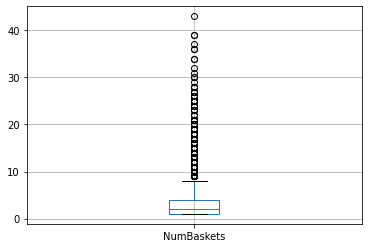

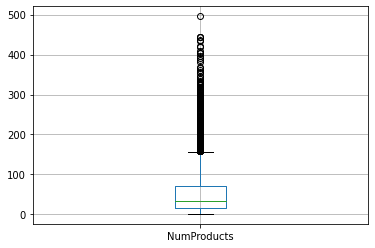

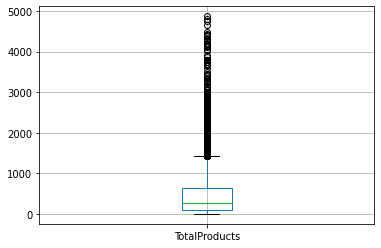

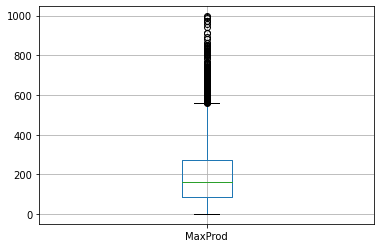

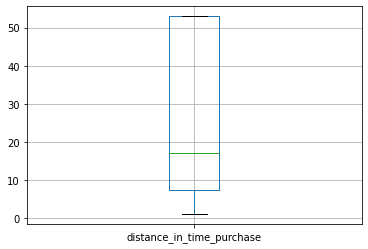

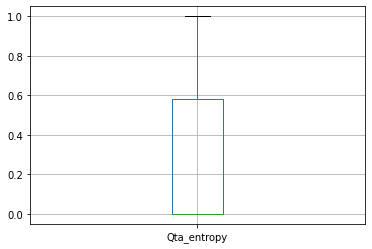

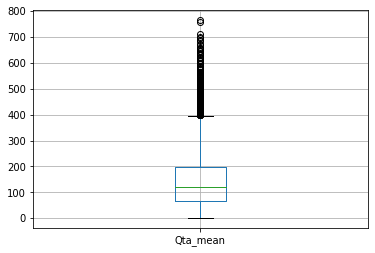

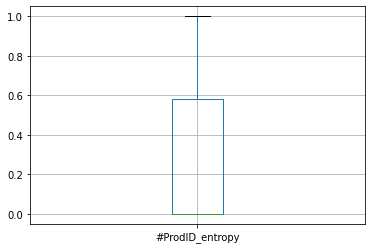

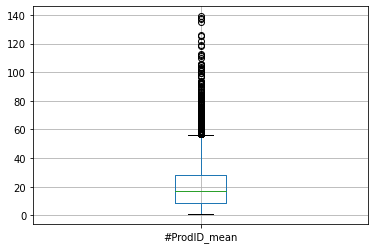

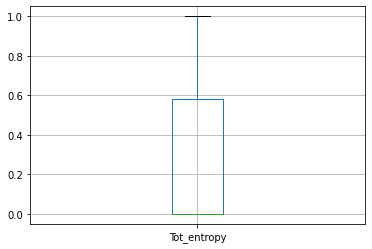

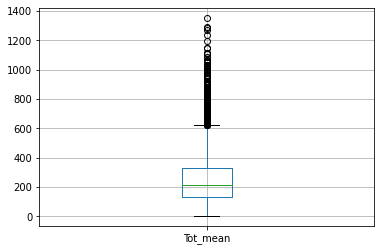

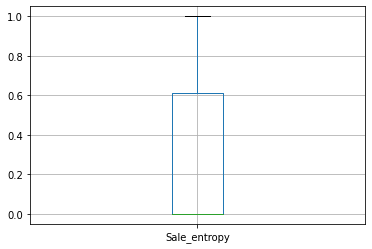

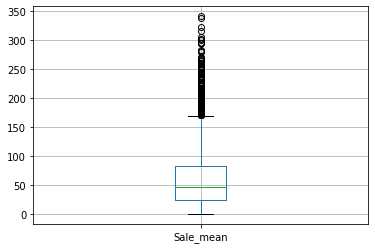

<Figure size 432x288 with 0 Axes>

In [ ]:
for column in columns:
  clean_data.hist(column=column, bins=100, figsize = (10,5))
  plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/Cleaned/'+ column +'_hist.pdf')
  plt.show()
  plt.clf()

for column in columns:
  clean_data.boxplot(column=column, figsize = (10,5))
  plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/Cleaned/'+ column +'_boxplot.pdf')
  plt.show()
  plt.clf()

### Normalization

In [8]:
normalized_data = clean_data.copy()

for to_normalize in columns:
  normalized_data[to_normalize] = (clean_data[to_normalize] - clean_data[to_normalize].mean()) / clean_data[to_normalize].std()

for to_normalize in columns:
  normalized_data[to_normalize] = (normalized_data[to_normalize] - normalized_data[to_normalize].min()) / (normalized_data[to_normalize].max() - normalized_data[to_normalize].min())

In [ ]:
normalized_data.describe()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean
count,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000
mean,15309.597080,0.063249,0.109139,0.103617,0.202071,0.504197,0.267264,0.193016,0.242781,0.148237,0.256532,0.187772,0.284535,0.176307
std,1715.635252,0.101117,0.125422,0.135399,0.161800,0.409830,0.323076,0.148708,0.310417,0.130530,0.321736,0.134321,0.336149,0.144312
min,12347.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13833.500000,0.000000,0.028283,0.021565,0.083333,0.122115,0.000000,0.087842,0.000000,0.057971,0.000000,0.096461,0.000000,0.072594
50%,15316.500000,0.023810,0.064646,0.053399,0.160643,0.307692,0.000000,0.155963,0.000000,0.114130,0.000000,0.157603,0.000000,0.139115
75%,16780.750000,0.071429,0.143434,0.129801,0.275100,1.000000,0.579380,0.258945,0.579380,0.195652,0.579380,0.242512,0.612602,0.242893
max,18287.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


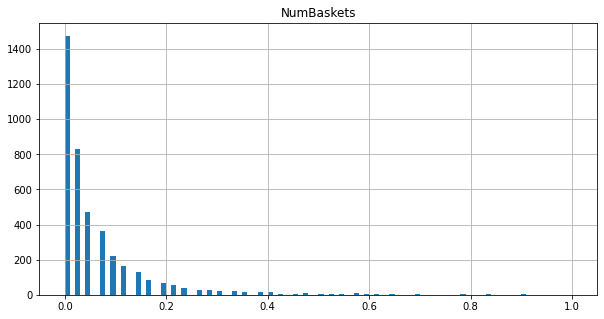

<Figure size 432x288 with 0 Axes>

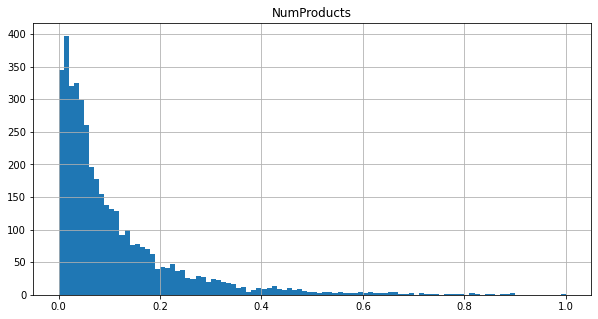

<Figure size 432x288 with 0 Axes>

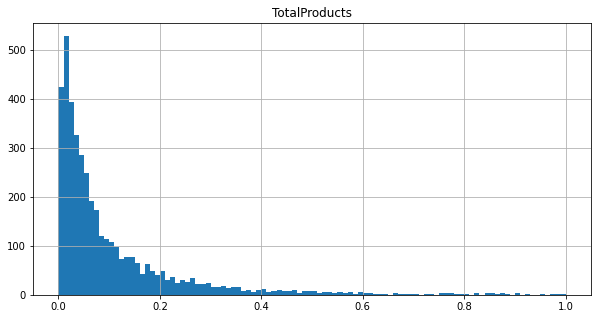

<Figure size 432x288 with 0 Axes>

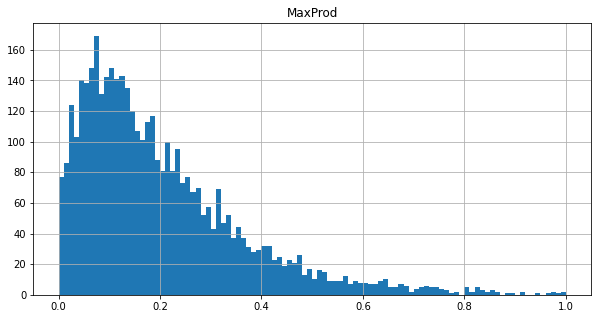

<Figure size 432x288 with 0 Axes>

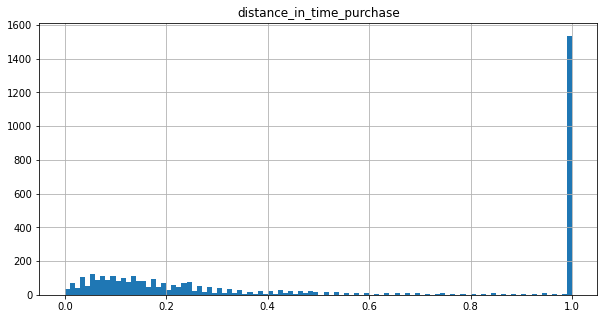

<Figure size 432x288 with 0 Axes>

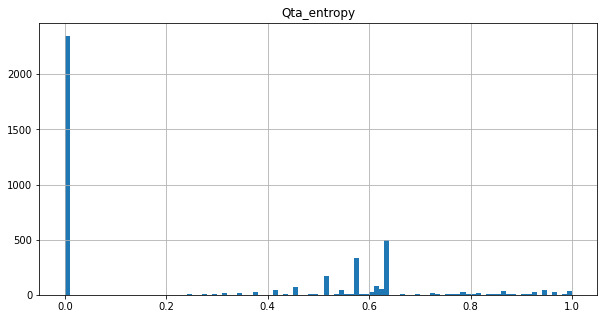

<Figure size 432x288 with 0 Axes>

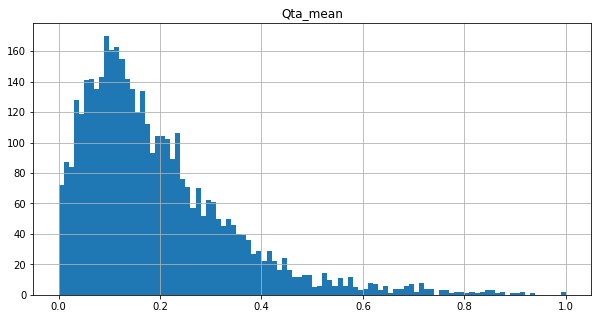

<Figure size 432x288 with 0 Axes>

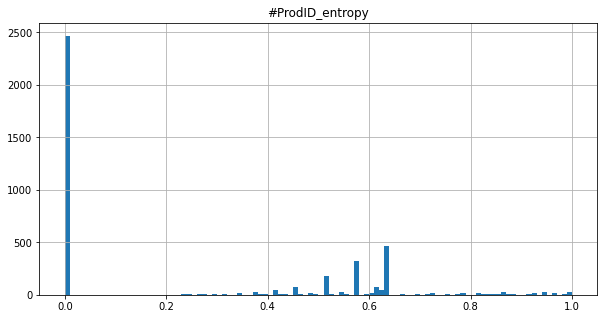

<Figure size 432x288 with 0 Axes>

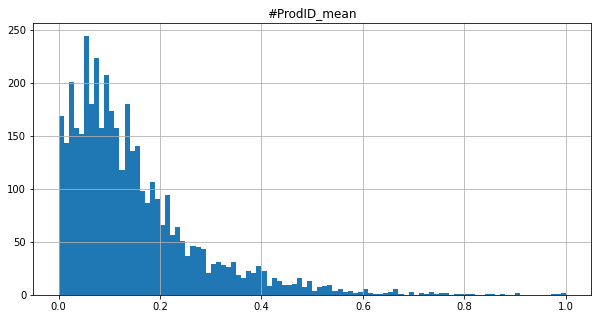

<Figure size 432x288 with 0 Axes>

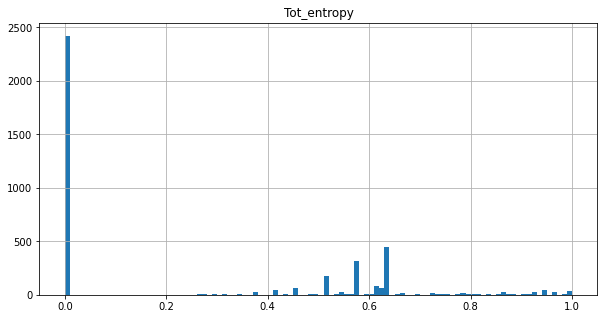

<Figure size 432x288 with 0 Axes>

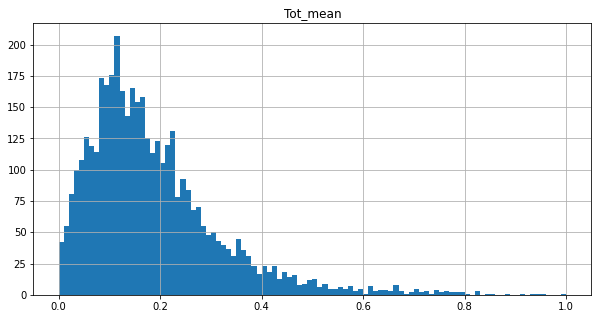

<Figure size 432x288 with 0 Axes>

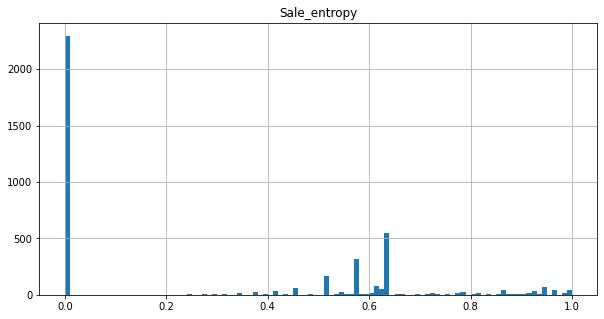

<Figure size 432x288 with 0 Axes>

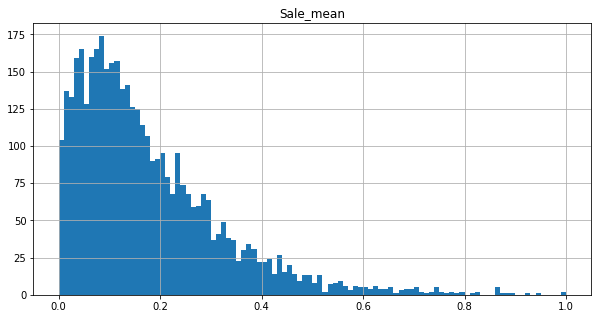

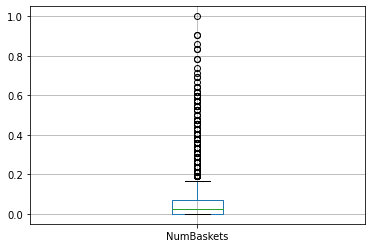

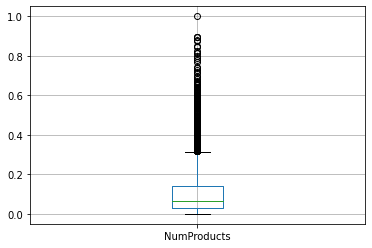

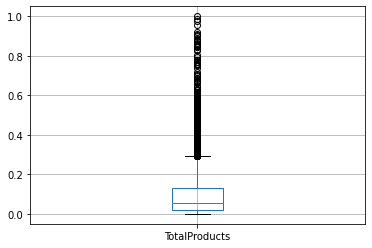

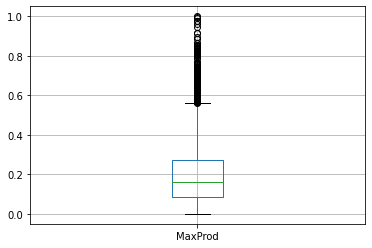

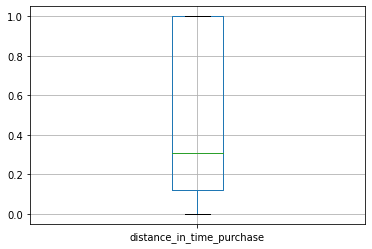

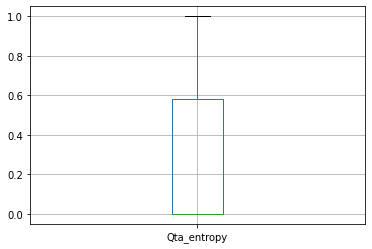

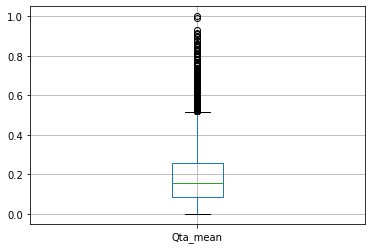

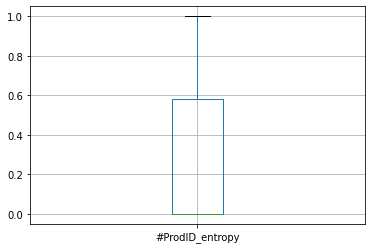

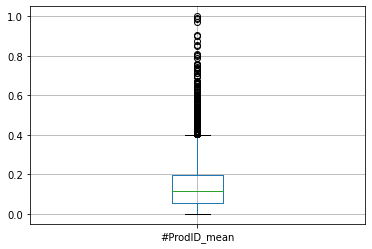

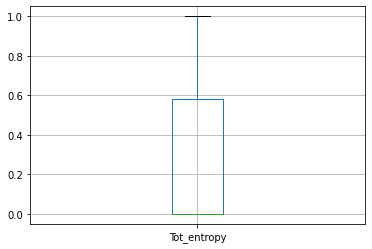

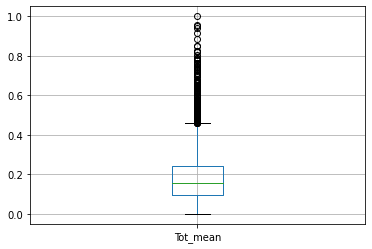

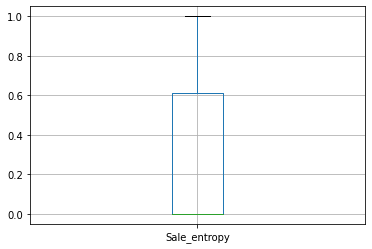

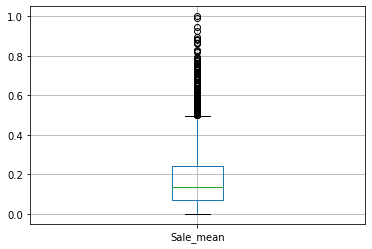

<Figure size 432x288 with 0 Axes>

In [ ]:
for column in columns:
  normalized_data.hist(column=column, bins=100, figsize = (10,5))
  plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/Normalized/'+ column +'_hist.pdf')
  plt.show()
  plt.clf()

for column in columns:
  normalized_data.boxplot(column=column, figsize = (10,5))
  plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/Normalized/'+ column +'_boxplot.pdf')
  plt.show()
  plt.clf()

In [ ]:
normalized_data.head()

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean
0,12347.0,0.142857,0.191919,0.364140,0.496988,0.147436,0.621610,0.330837,0.373304,0.161491,0.544568,0.322498,0.373304,0.175731
1,12348.0,0.047619,0.010101,0.028548,0.095382,0.134615,0.579380,0.059851,0.000000,0.007246,0.000000,0.020897,0.000000,0.002963
2,12349.0,0.000000,0.131313,0.108647,0.531124,1.000000,0.000000,0.693316,0.000000,0.471014,0.000000,0.848332,0.000000,0.777158
3,12350.0,0.000000,0.030303,0.040049,0.195783,1.000000,0.000000,0.255570,0.000000,0.108696,0.000000,0.217007,0.000000,0.073371
4,12352.0,0.142857,0.113131,0.107825,0.124498,0.099359,0.544568,0.097173,0.621610,0.072464,0.373304,0.145460,0.621610,0.130666


### Correlation

In [ ]:
normalized_data.corr("kendall")

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean
CustomerID,1.000000,0.002433,0.006235,-0.052262,-0.070081,0.000652,-0.008224,-0.075176,0.005623,0.012614,0.007125,-0.074729,0.004779,0.015357
NumBaskets,0.002433,1.000000,0.522248,0.597463,0.306254,-0.729901,0.521504,0.108720,0.490355,0.081665,0.524466,0.110129,0.534061,0.067026
NumProducts,0.006235,0.522248,1.000000,0.684614,0.554779,-0.410926,0.354591,0.438563,0.362484,0.595517,0.371103,0.462515,0.310588,0.502886
TotalProducts,-0.052262,0.597463,0.684614,1.000000,0.717997,-0.473742,0.409965,0.555831,0.375067,0.376361,0.410889,0.474909,0.360195,0.270500
MaxProd,-0.070081,0.306254,0.554779,0.717997,1.000000,-0.252799,0.308970,0.774116,0.266441,0.485499,0.292799,0.628895,0.201105,0.335269
distance_in_time_purchase,0.000652,-0.729901,-0.410926,-0.473742,-0.252799,1.000000,-0.490829,-0.075370,-0.460408,-0.045089,-0.485798,-0.076094,-0.488510,-0.035278
Qta_entropy,-0.008224,0.521504,0.354591,0.409965,0.308970,-0.490829,1.000000,0.102875,0.541908,0.049402,0.635831,0.089340,0.454867,0.037907
Qta_mean,-0.075176,0.108720,0.438563,0.555831,0.774116,-0.075370,0.102875,1.000000,0.087638,0.555587,0.106317,0.714698,0.038479,0.376108
#ProdID_entropy,0.005623,0.490355,0.362484,0.375067,0.266441,-0.460408,0.541908,0.087638,1.000000,0.082155,0.572261,0.092747,0.423155,0.072401
#ProdID_mean,0.012614,0.081665,0.595517,0.376361,0.485499,-0.045089,0.049402,0.555587,0.082155,1.000000,0.071580,0.612653,-0.006511,0.724899


In [ ]:
normalized_data.corr("spearman")

,CustomerID,NumBaskets,NumProducts,TotalProducts,MaxProd,distance_in_time_purchase,Qta_entropy,Qta_mean,#ProdID_entropy,#ProdID_mean,Tot_entropy,Tot_mean,Sale_entropy,Sale_mean
CustomerID,1.000000,0.003364,0.009356,-0.078190,-0.104628,0.000845,-0.011120,-0.112358,0.007633,0.018887,0.009365,-0.111218,0.006293,0.023472
NumBaskets,0.003364,1.000000,0.677606,0.754827,0.417534,-0.856709,0.664403,0.150501,0.624932,0.112724,0.663071,0.152519,0.675251,0.093143
NumProducts,0.009356,0.677606,1.000000,0.861967,0.744072,-0.561858,0.476537,0.613694,0.483145,0.770813,0.495836,0.638454,0.421446,0.688366
TotalProducts,-0.078190,0.754827,0.861967,1.000000,0.881144,-0.638544,0.551547,0.726803,0.505950,0.532911,0.550811,0.659077,0.489428,0.396823
MaxProd,-0.104628,0.417534,0.744072,0.881144,1.000000,-0.356891,0.408475,0.924245,0.353166,0.660124,0.387332,0.818044,0.272028,0.482330
distance_in_time_purchase,0.000845,-0.856709,-0.561858,-0.638544,-0.356891,1.000000,-0.630207,-0.107644,-0.588977,-0.064384,-0.619852,-0.109074,-0.626068,-0.051206
Qta_entropy,-0.011120,0.664403,0.476537,0.551547,0.408475,-0.630207,1.000000,0.138923,0.619381,0.066508,0.717175,0.119537,0.539953,0.051352
Qta_mean,-0.112358,0.150501,0.613694,0.726803,0.924245,-0.107644,0.138923,1.000000,0.116414,0.732061,0.142593,0.886339,0.053395,0.535560
#ProdID_entropy,0.007633,0.624932,0.483145,0.505950,0.353166,-0.588977,0.619381,0.116414,1.000000,0.109199,0.652679,0.123811,0.498224,0.095451
#ProdID_mean,0.018887,0.112724,0.770813,0.532911,0.660124,-0.064384,0.066508,0.732061,0.109199,1.000000,0.095667,0.771964,-0.006242,0.895450


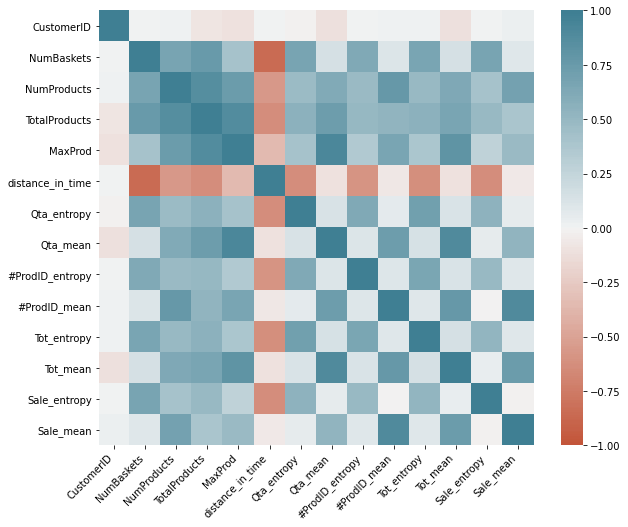

In [17]:
import seaborn as sns
corr = normalized_data.corr("spearman")

f = plt.figure(figsize=(10, 8))
ax = f.add_subplot()
im = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax = ax
)
im.set_xticklabels(
    im.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/correlation_matrix_spearman.png')

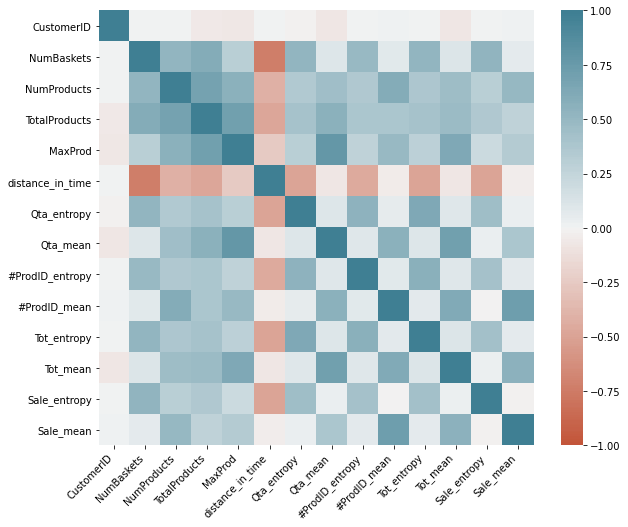

In [18]:
corr = normalized_data.corr("kendall")

f = plt.figure(figsize=(10, 8))
ax = f.add_subplot()
im = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax = ax
)
im.set_xticklabels(
    im.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/correlation_matrix_kendall.png')

In [ ]:
new_columns = [
  'TotalProducts',
  'distance_in_time_purchase',
  'Qta_entropy',
  'Qta_mean',
  'Sale_entropy',
  'Sale_mean'
]

In [ ]:
data_final = normalized_data[new_columns]

In [ ]:
data_final.corr("spearman")

,TotalProducts,distance_in_time_purchase,Qta_entropy,Qta_mean,Sale_entropy,Sale_mean
TotalProducts,1.000000,-0.638544,0.551547,0.726803,0.489428,0.396823
distance_in_time_purchase,-0.638544,1.000000,-0.630207,-0.107644,-0.626068,-0.051206
Qta_entropy,0.551547,-0.630207,1.000000,0.138923,0.539953,0.051352
Qta_mean,0.726803,-0.107644,0.138923,1.000000,0.053395,0.535560
Sale_entropy,0.489428,-0.626068,0.539953,0.053395,1.000000,-0.010286
Sale_mean,0.396823,-0.051206,0.051352,0.535560,-0.010286,1.000000


In [ ]:
data_final.corr("kendall")

,TotalProducts,distance_in_time_purchase,Qta_entropy,Qta_mean,Sale_entropy,Sale_mean
TotalProducts,1.000000,-0.473742,0.409965,0.555831,0.360195,0.270500
distance_in_time_purchase,-0.473742,1.000000,-0.490829,-0.075370,-0.488510,-0.035278
Qta_entropy,0.409965,-0.490829,1.000000,0.102875,0.454867,0.037907
Qta_mean,0.555831,-0.075370,0.102875,1.000000,0.038479,0.376108
Sale_entropy,0.360195,-0.488510,0.454867,0.038479,1.000000,-0.009902
Sale_mean,0.270500,-0.035278,0.037907,0.376108,-0.009902,1.000000


### Visualization

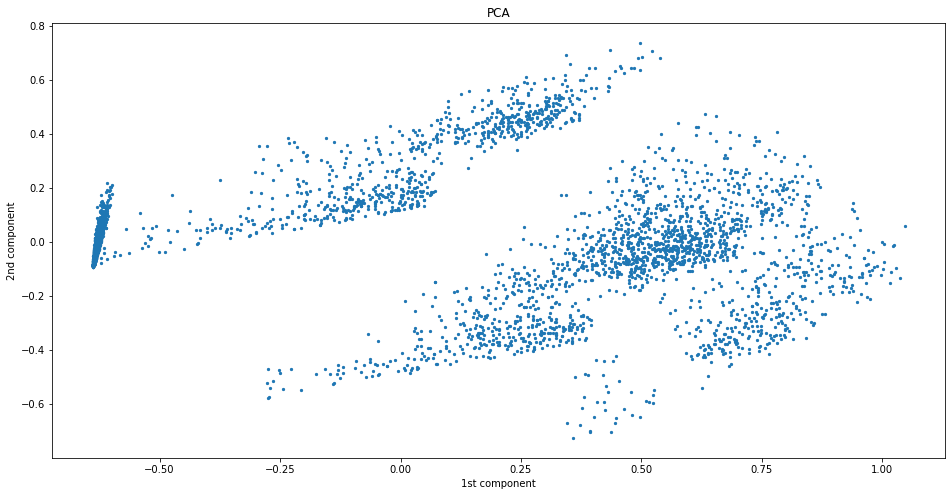

In [ ]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=3).fit_transform(
    data_final
)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.Set1, s=5)
plt.title("PCA")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/pca_2d.png')

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

X_pca = PCA(n_components=3).fit_transform(
    data_final
)

x = X_pca[:,0]
y = X_pca[:,1]
z = X_pca[:,2]

fig = px.scatter_3d(X_pca, x=x, y=y, z=z)
fig.update_traces(marker=dict(size=5))

fig.show()

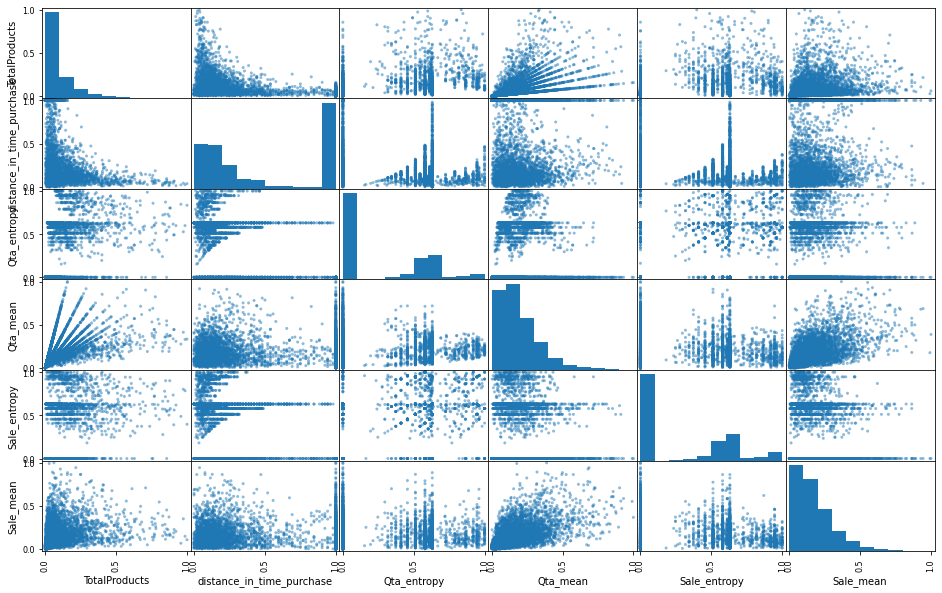

In [ ]:
pd.plotting.scatter_matrix(data_final,figsize=(16,10))
plt.savefig('/content/drive/MyDrive/DM/Clustering/Plots/Data_Preparation/Indicators/scatter_matrix.png')
plt.show()

In [ ]:
data_final.to_csv('/content/drive/MyDrive/DM/Clustering/customer_indicators.csv')